# **Network Traffic Anomaly Detection using BiLSTM**


URL for Downloading Dataset.


In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_anomaly_detection_L3/DataSets.zip

--2024-03-10 13:29:02--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_anomaly_detection_L3/DataSets.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402533304 (384M) [application/zip]
Saving to: ‘DataSets.zip.1’

DataSets.zip.1      100%[===================>] 383.88M  33.7MB/s    in 12s     

2024-03-10 13:29:15 (32.7 MB/s) - ‘DataSets.zip.1’ saved [402533304/402533304]



Import the necessary libraries to use in this lab. We can add some aliases (such as pd, plt, np, tf) to make the libraries easier to use in our code and set a default figure size for further plots. Ignore the warnings.


In [2]:
!pip install gensim
!pip install python-Levenshtein
!pip install tensorflow==2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 57.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.8/170.8 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.7/394.7 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 80.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 100.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 kB 57.0 MB/s eta

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ElTree
import re, h5py, itertools, math, glob, zipfile, os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import log_loss, auc, roc_curve
from tensorflow.keras import layers
from keras.layers.core import Masking
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, TimeDistributed
from keras.layers.wrappers import Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from tensorflow.python.client import device_lib
from lxml import etree
from gensim.models import Word2Vec

# %matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore")

2024-03-10 13:30:27.783677: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-10 13:30:27.783734: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Matplotlib is building the font cache; this may take a moment.
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
Using TensorFlow backend.


## Some additional & preparative actions


Specify the value of the `precision` parameter equal to 3 to display three decimal signs (instead of 6 as default).


In [4]:
pd.set_option("precision", 3)
pd.options.display.float_format = '{:.3f}'.format

In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]
    
    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'
    
    plt.rc('legend', fontsize = 14)   # legend fontsize
    plt.rc('figure', titlesize = 12)  # fontsize of the figure title
        
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    
    ## Accuracy
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

class B_Generator(object):
    def __init__(self, BZ, XX, YY, ohe):
        self.BZ = BZ
        self.n_b = int(math.floor(np.shape(XX)[0] / BZ))
        self.b_index = [a * BZ for a in range(0, self.n_b)]
        self.XX = XX
        self.YY = YY
        self.ohe = ohe
        
    def __iter__(self):
        for var_0 in itertools.cycle(self.b_index):
            YY = self.YY[var_0 : (var_0 + self.BZ)]
            ohe_Y = self.ohe.transform(YY.reshape(len(YY), 1))
            yield (self.XX[var_0 : (var_0 + self.BZ),], ohe_Y)

## Reading the Dataset


In [6]:
number = 2

if zipfile.is_zipfile('DataSets.zip'):
  file_1 = zipfile.ZipFile('DataSets.zip', 'r')
else:
  print('Type file isn`t ZIP')

name_dataset = file_1.namelist()[number]
file_1.extract(name_dataset)
print("File", name_dataset, "has been read")

File TestbedSunJun13Flows.xml has been read


## Dataset manipulations


In [7]:
tree_set = ElTree.parse(name_dataset)
root_tree_set = tree_set.getroot()

result = []
var_1 = root_tree_set.items()[0][1][:-4]

for item in root_tree_set.findall(var_1):
    result.append({node.tag: node.text for node in item.getiterator()})

dSET = pd.DataFrame(result)
dSET = dSET.drop(dSET.columns[[0]], axis = 1)
dSET = dSET.drop_duplicates()

dSET = dSET.sort_values('startDateTime')
dSET['IPs_sequence'] = dSET['source'] + '_' + dSET['destination'] + '_' + dSET['startDateTime'].str[:13]

dSET['res_port'] = np.where(dSET.destinationPort <= dSET.sourcePort,
                            dSET['destinationPort'],
                            dSET['sourcePort'])

# rename some of the columns for more convenience
dSET = dSET.rename(columns = {'totalSourceBytes': 'totSB',
                        'totalDestinationBytes': 'totDB',
                        'totalDestinationPackets': 'totDP',
                        'totalSourcePackets': 'totSP',
                        'sourcePayloadAsBase64': 'sourB64',
                        'sourcePayloadAsUTF': 'sourUTF',
                        'destinationPayloadAsBase64': 'destB64',
                        'destinationPayloadAsUTF': 'destUTF',
                        'direction': 'direct',
                        'sourceTCPFlagsDescription': 'sourTCPFd',
                        'destinationTCPFlagsDescription': 'destTCPFd',
                        'protocolName': 'pName',
                        'sourcePort': 'sPort',
                        'destination': 'dest',
                        'destinationPort': 'dPort'})
print("Preparation process has been finished")

Preparation process has been finished


### Let's look at the dataset size & feature names


In [8]:
dSET.shape, dSET.columns

((137160, 22),
 Index(['appName', 'totSB', 'totDB', 'totDP', 'totSP', 'sourB64', 'sourUTF',
        'destB64', 'destUTF', 'direct', 'sourTCPFd', 'destTCPFd', 'source',
        'pName', 'sPort', 'dest', 'dPort', 'startDateTime', 'stopDateTime',
        'Tag', 'IPs_sequence', 'res_port'],
       dtype='object'))

The dataset contains a lot of objects (rows) depending on a selected file, for each of which `20` features are set (columns), including 1 target feature (`Tag`) and two additional columns (`IPs_sequence` and `res_port`).


Input features (column names):

1.  `appName` - name of the application that participated in this data collection.
2.  `totalSourceBytes`, `totSB` - the amount of data received in bytes from Source.
3.  `totalDestinationBytes`, `totDB` - the amount of data sent in bytes to Destination.
4.  `totalDestinationPackets`, `totDP` - the amount of data sent in packets to Destination.
5.  `totalSourcePackets`, `totSP` - the amount of data received in packets from Source.
6.  `sourcePayloadAsBase64`, `sourB64` - source payload in Base64 code.
7.  `sourcePayloadAsUTF`, `sourUTF` - source payload in another UTF-8 (Unicode Transformation Format) 8-bit code.
8.  `destinationPayloadAsBase64`, `destB64` - destination payload in Base64 code.
9.  `destinationPayloadAsUTF`, `destUTF` – destination payload in another UTF-8 (Unicode Transformation Format) 8-bit code.
10. `direction`, `direct` - data transferring direction, for instance, local-to-local (`L2L`), local-to-remote (`L2R`), remote-to-local (`R2L`), remote-to-remote (`R2R`).
11. `sourceTCPFlagsDescription`, `sourTCPFd` - sources description of the TCP flags, for instance, `ACKnowledgement`, `A`: flag is used to acknowledge the successful receipt of packets; `Push`, `P` flag, like the `Urgent flag`: exists to ensure that the data is given the priority (that it deserves) and is processed at the sending or receiving end; `Final`, `F` flag: available is the FIN flag, standing for the word FINished, etc.
12. `destinationTCPFlagsDescription`, `destTCPFd` - destination description of the TCP flags, description see above.
13. `source` – source IP-address.
14. `protocolName`, `pName` – name of used protocol.
15. `sourcePort`, `sPort` – number of source port.
16. `desctination`, `dest` – destination IP-address.
17. `desctinationPort`, `dPort` – number of destination port.
18. `startDateTime`, `stopDateTime` – date & time of start and stop of data collection process.
19. `Tag` – a feature (desired target) value that will be used for prediction.


Let's read the data and look at the first 5 rows using the `head` method. The number of the output rows from the dataset is determined by the `head` method parameter.

Replace `##YOUR CODE GOES HERE##` with your Python code.


In [9]:

dSET.head(5)

,appName,totSB,totDB,totDP,totSP,sourB64,sourUTF,destB64,destUTF,direct,...,source,pName,sPort,dest,dPort,startDateTime,stopDateTime,Tag,IPs_sequence,res_port
0,Unknown_UDP,2633658,0,0,28971,None,None,None,None,L2R,...,192.168.5.122,udp_ip,5353,224.0.0.251,5353,2010-06-12T23:57:24,2010-06-13T09:24:52,Normal,192.168.5.122_224.0.0.251_2010-06-12T23,5353
2,HTTPWeb,64,128,2,1,None,None,None,None,L2L,...,192.168.2.113,tcp_ip,4191,192.168.5.122,80,2010-06-12T23:57:38,2010-06-12T23:59:20,Normal,192.168.2.113_192.168.5.122_2010-06-12T23,4191
4,HTTPWeb,128,64,1,2,None,None,None,None,L2R,...,192.168.2.113,tcp_ip,4192,207.241.148.80,80,2010-06-12T23:57:40,2010-06-12T23:59:20,Normal,192.168.2.113_207.241.148.80_2010-06-12T23,4192
6,HTTPImageTransfer,128,128,2,2,None,None,None,None,L2R,...,192.168.2.110,tcp_ip,1864,216.49.88.12,80,2010-06-12T23:57:42,2010-06-12T23:59:22,Normal,192.168.2.110_216.49.88.12_2010-06-12T23,1864
8,SecureWeb,64,0,0,1,None,None,None,None,L2R,...,192.168.2.113,tcp_ip,4186,63.245.209.72,443,2010-06-12T23:58:11,2010-06-12T23:59:07,Normal,192.168.2.113_63.245.209.72_2010-06-12T23,4186


## Main pipeline


In [10]:
## Build the sets (keys and sequences) in hour slices
print("Stage I. Keys building\n")
key = dSET.groupby('IPs_sequence')[['Tag', 'res_port']].agg({"Tag": lambda var_2: "%s" % ','.join([var_3 for var_3 in var_2]),
          "res_port" :lambda var_2: "%s" % ','.join([str(var_3) if int(var_3) < 10000 else "10000" for var_3 in var_2])})

print("Unique keys:\n" + str(key.count()))
attacks = [var_4.split(",") for var_4 in key.Tag.tolist()]
sequences = [var_4.split(",") for var_4 in key.res_port.tolist()]

Stage I. Keys building

Unique keys:
Tag         11243
res_port    11243
dtype: int64


In [11]:
print("Stage II. Label encoding\n")
U_tokens = list(set([var_5 for var_6 in sequences for var_5 in var_6]))
print("Number of unique tokens :", len(U_tokens))
LE = LabelEncoder().fit(U_tokens)
sequences = [LE.transform(var_7).tolist() for var_7 in sequences]
sequences = [[var_6 + 1 for var_6 in var_5] for var_5 in sequences]
print("Number of sequences :", len(sequences))
sequence_attack = zip(attacks, sequences)

Stage II. Label encoding

Number of unique tokens : 4168
Number of sequences : 11243


In [12]:
print("Stage III. Sequences generating for the future model\n")
var_8 = np.float32(0)
len_sequence = 10
print("Length of the primary sequence :", len_sequence)
seq_IDX, seq_X, seq_Y, seq_ATT = [], [], [], []
for var_10, (var_11, var_12) in enumerate(sequence_attack):
    sequence_1 = [np.float32(0)] * (len_sequence) + var_12
    sequence_2 = [np.float32(0)] * (len_sequence) + var_11
    for var_9 in range(len_sequence, len(sequence_1)):
        sequence_3 = sequence_1[(var_9 - len_sequence):(var_9)]
        var_14 = []
        for var_13 in sequence_3:
            try:
                var_14.append(var_13)
            except:
                var_14.append(var_8)
        seq_X.append(var_14)
        seq_Y.append(sequence_1[var_9])
        seq_IDX.append(var_10)
        seq_ATT.append(sequence_2[var_9])
print("Length of X & Y sets :", len(seq_X))

Stage III. Sequences generating for the future model

Length of the primary sequence : 10
Length of X & Y sets : 137160


In [13]:
print("Stage IV. One-hot-encoder initializing\n")
OHE = OneHotEncoder(sparse = False, categories = 'auto').fit(np.unique(seq_Y).reshape(-1, 1))

X = np.array(seq_X)
print("Dimensionality size of set X :", X.shape)

Stage IV. One-hot-encoder initializing

Dimensionality size of set X : (137160, 10)


In [14]:
print("Stage V. Model building\n")
drop_level = 0.35 # You can choose a drop level yourself
N_neurons = 50   # You can choose the number of neurons yourself

model = Sequential()
model.add(layers.Embedding(output_dim = 100,
                    input_dim = len(U_tokens) + 1,
                    mask_zero = True))

model.add(layers.Bidirectional(LSTM(N_neurons, return_sequences = True)))
model.add(layers.Dropout(drop_level))

# model.add(layers.Bidirectional(LSTM(N_neurons, activation = "relu", return_sequences = False))
# model.add(layers.Dropout(drop_level))

model.add(layers.Bidirectional(LSTM(N_neurons, activation = "relu", return_sequences = False)))
model.add(layers.Dropout(drop_level))

model.add(layers.Dense(N_neurons, activation = "linear"))
model.add(layers.Dropout(drop_level))

model.add(layers.Dense(len(U_tokens), activation = "softmax"))

##YOUR CODE GOES HERE##.summary()
model.summary()

Stage V. Model building



2024-03-10 13:32:35.218743: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-10 13:32:35.219271: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-10 13:32:35.219296: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-10 13:32:35.219326: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyterlab-itsrealkarth): /proc/driver/nvidia/version does not exist
2024-03-10 13:32:35.219666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow w

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         416900    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 100)         60400     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [16]:
print("Stage VI. Compile and fit the model\n")

batch_size = 512  # You can choose a batch size yourself
n_epochs = 100     # You can choose the number of epochs yourself

optim = tf.keras.optimizers.Nadam()   # You can choose an optimizer yourself
loss_f = tf.keras.metrics.categorical_crossentropy

T_data = B_Generator(batch_size, np.asarray(X), np.asarray(seq_Y), OHE)

model.compile(loss = loss_f,
              optimizer = optim,
              metrics = ['accuracy'])

history = model.fit_generator(T_data.__iter__(),
    steps_per_epoch = T_data.n_b,
    epochs = n_epochs,
    verbose = 1)

Stage VI. Compile and fit the model

Epoch 1/100
267/267 [==============================] - 142s 499ms/step - loss: 7.2763 - accuracy: 0.1979
Epoch 2/100
267/267 [==============================] - 131s 492ms/step - loss: 6.3884 - accuracy: 0.2246
Epoch 3/100
267/267 [==============================] - 131s 491ms/step - loss: 6.1470 - accuracy: 0.2252
Epoch 4/100
267/267 [==============================] - 130s 486ms/step - loss: 5.9962 - accuracy: 0.2281
Epoch 5/100
267/267 [==============================] - 131s 492ms/step - loss: 5.7910 - accuracy: 0.2386
Epoch 6/100
267/267 [==============================] - 131s 490ms/step - loss: 5.6295 - accuracy: 0.2441
Epoch 7/100
267/267 [==============================] - 130s 488ms/step - loss: 5.4821 - accuracy: 0.2483
Epoch 8/100
267/267 [==============================] - 130s 488ms/step - loss: 5.3188 - accuracy: 0.2538
Epoch 9/100
267/267 [==============================] - 129s 485ms/step - loss: 5.1359 - accuracy: 0.2604
Epoch 10/100
267/2

Stage VII. Results visualization



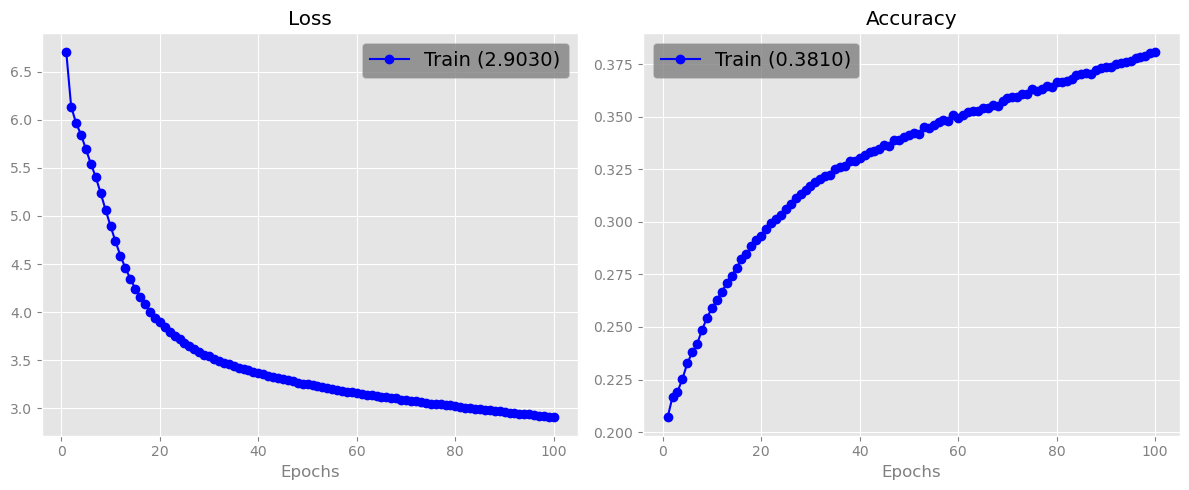

In [18]:
print("Stage VII. Results visualization\n")
plot_history(history)

In [ ]:
print("Stage VIII. Model saving & prediction checking\n")

M_name = "model"

filepath = M_name + '.h5'
tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)
print("Size of the saved model :", os.stat(filepath).st_size, "bytes")

In [ ]:
model_L = tf.keras.models.load_model(##YOUR CODE GOES HERE##)
predicts = model_L.predict(X, batch_size = batch_size)
print("Dimensionality sizes of model predicts :", predicts.shape, "\n")
print("Compare with length of X & Y sets :\t", len(seq_X), "\nand with number of tokens :\t\t", len(U_tokens))